In [10]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_bar, theme_minimal, theme, element_text, coord_flip, labs

In [3]:
# Read the data
ames = pd.read_csv("https://www.dropbox.com/scl/fi/g0n5le5p6fr136ggetfsf/AmesHousing.csv?rlkey=jlr9xtz1o6u5rghfo29a5c02f&dl=1")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [4]:
X = ames.drop(["SalePrice", "Order", "PID"], axis=1)
y = ames["SalePrice"]

# Create ColumnTransformer
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

# Create pipelines for Linear and Ridge Regression
lr_pipeline = Pipeline([
    ("preprocessing", ct),
    ("linear_regression", LinearRegression())
])

ridge_pipeline = Pipeline([
    ("preprocessing", ct),
    ("ridge_regression", Ridge(alpha=1))
])

# Cross-validate both pipelines
lr_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='r2')
ridge_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='r2')

# Print cross-validation scores
print("Linear Regression cross-validation R^2 scores:", lr_scores)
print("Mean R^2 for Linear Regression:", np.mean(lr_scores))
print("Ridge Regression cross-validation R^2 scores:", ridge_scores)
print("Mean R^2 for Ridge Regression:", np.mean(ridge_scores))

Linear Regression cross-validation R^2 scores: [-2.59303720e+21 -1.13145211e+19 -7.57138616e+20 -4.47669752e+18
 -2.55949915e+20]
Mean R^2 for Linear Regression: -7.243833902756543e+20
Ridge Regression cross-validation R^2 scores: [0.89815807 0.91744024 0.79493606 0.78522563 0.91389818]
Mean R^2 for Ridge Regression: 0.8619316345217338


In [5]:
lr_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f908bba38b0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f908bba2c80>)])),
                ('linear_regression', LinearRegression())])

In [6]:
ridge_pipeline.fit(X, y)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f908bba38b0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f908bba2c80>)])),
                ('ridge_regression', Ridge(alpha=1))])

In [7]:
lr_coefs = pd.Series(
    lr_pipeline.named_steps["linear_regression"].coef_,
    index=ct.get_feature_names_out()
)
ridge_coefs = pd.Series(
    ridge_pipeline.named_steps["ridge_regression"].coef_,
    index=ct.get_feature_names_out()
)

coef_df = pd.DataFrame({
    "Feature": lr_coefs.index,
    "Linear Regression Coefficients": lr_coefs.values,
    "Ridge Regression Coefficients": ridge_coefs.values
})

In [8]:
coef_melted = coef_df.melt(id_vars=["Feature"],
                           value_vars=["Linear Regression Coefficients", "Ridge Regression Coefficients"],
                           var_name="Model",
                           value_name="Coefficient")

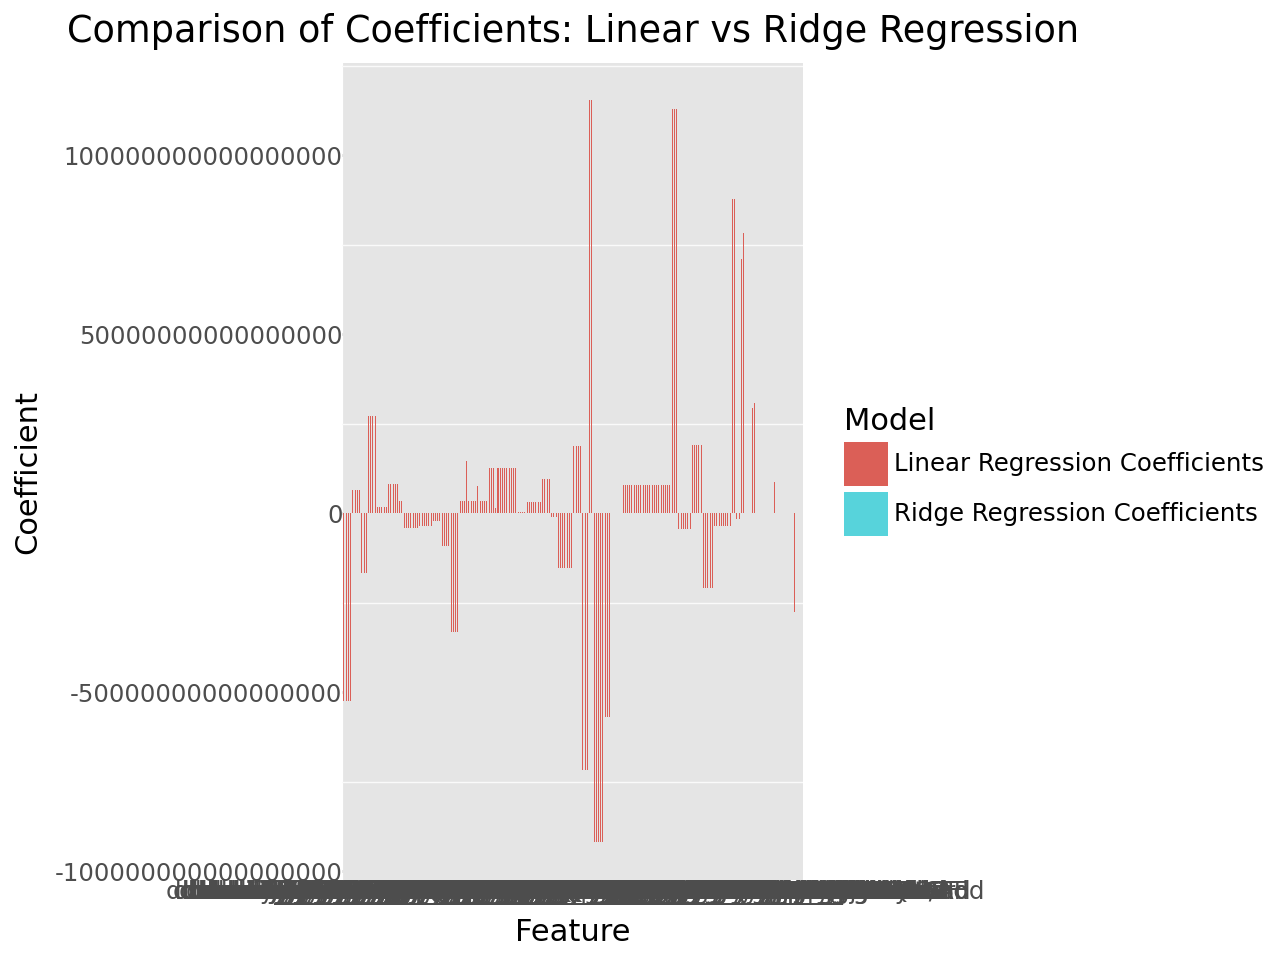

In [11]:
plot = (ggplot(coef_melted, aes(x='Feature', y='Coefficient', fill='Model')) +
        geom_bar(stat='identity', position='dodge') +
        theme_minimal() +
        labs(title='Comparison of Coefficients: Linear vs Ridge Regression',
             x='Feature',
             y='Coefficient')
       )

plot